In [1]:
import cached
import cpr_gym
import git
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import psutil
import seaborn as sns
import threadpoolctl
import time
import torch
import warnings
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

tqdm.pandas()
torch.set_num_threads = 1

print("cpr_lib_version: " + cpr_gym.engine.cpr_lib_version)

repo = git.Repo(".", search_parent_directories=True)
os.chdir(repo.working_tree_dir)

cpr_gym: Editable install detected. Load DLL from _build directory.
cpr_gym: __version__ = v0.7.0-141-ge06a12b (engine: v0.7.0-140-gc2da156-dirty)
cpr_lib_version: v0.7.0-140-gc2da156-dirty


In [2]:
episode_len = 2048
n_episodes = 100
batches = [
    # "2023-01-18_all-protos-0",
    # "2023-01-19_nakamoto-0",
    # "2023-01-19_all-protos-0",
    # "2023-01-20_tailstorm-0",
    # "2023-01-20_tailstorm-discount",
    # "2023-01-23_non-discount-low-alpha",
    # "2023-01-25_bk-8-long-0",  # not so long since I forgot to push the changes before launch
    # "2023-01-25_tailstorm-discount-0",
    # "2023-02-01-alpha50",
    "2023-02-21_ent_coef",
    "2023-03-10_full",
    "2023-03-17_learning-rate",
    "2023-03-21_learning-rate",
]

protocol_args = dict(
    nakamoto=[],
    bk=["k", "reward"],
    tailstorm=["k", "reward", "subblock_selection"],
    tailstormll=["k", "reward", "subblock_selection"],
    tailstormjune=["k", "reward"],
)

env_name = "cpr_gym:cpr-v0"


def env_kwargs_of_row(x):
    return dict(
        protocol=x.protocol,
        protocol_args={k: x[k] for k in protocol_args[x.protocol]},
        alpha=x.alpha if "alpha" in x.keys() else 0,
        gamma=x.gamma if "gamma" in x.keys() else 0,
        defenders=42,
    )

# Data generation

## Find trained models

In [3]:
def models():
    for batch in batches:
        for m in pathlib.Path(f"data/models/{batch}").glob("ppo-*.zip"):
            frag = m.stem.split("-")
            protocol = frag.pop(1)

            ent_coef = 0
            for i, x in enumerate(frag):
                if x.startswith("entcoef"):
                    ent_coef = float(x.removeprefix("entcoef"))
                    frag.pop(i)

            learning_rate = "linear:1e-3"
            for i, x in enumerate(frag):
                if x.startswith("lr"):
                    learning_rate = x.removeprefix("lr")
                    frag.pop(i)

            shape = "raw"
            for i, x in enumerate(frag):
                if x in ["raw", "exp", "cut"]:
                    shape = x
                    frag.pop(i)

            if protocol == "nakamoto":
                yield dict(
                    protocol=protocol,
                    k=1,
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    batch=batch,
                    learning_rate=learning_rate,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["bk", "bkll"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward="constant",
                    subblock_selection="n/a",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    batch=batch,
                    learning_rate=learning_rate,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            elif protocol in ["tailstorm", "tailstormll"]:
                yield dict(
                    protocol=protocol,
                    k=int(frag.pop(1)),
                    reward=frag.pop(1),
                    subblock_selection="heuristic",
                    alpha=int(frag.pop(1).removeprefix("alpha")) / 100,
                    gamma=int(frag.pop(1).removeprefix("gamma")) / 100,
                    batch=batch,
                    learning_rate=learning_rate,
                    ent_coef=ent_coef,
                    shape=shape,
                    policy="-".join(frag),
                    path=m,
                )
            else:
                raise Exception(f"unsupported protocol: {protocol}")


models = pd.DataFrame(models()).assign(kind="trained", reuse="-")
models

,protocol,k,reward,subblock_selection,alpha,gamma,batch,learning_rate,ent_coef,shape,policy,path,kind,reuse
0,nakamoto,1,constant,n/a,0.45,0.95,2023-02-21_ent_coef,linear:1e-3,0.0001,raw,ppo-6vu6b9w6-best,data/models/2023-02-21_ent_coef/ppo-nakamoto-a...,trained,-
1,tailstorm,8,constant,heuristic,0.35,0.05,2023-02-21_ent_coef,linear:1e-3,0.0001,raw,ppo-pia2ch4q-best,data/models/2023-02-21_ent_coef/ppo-tailstorm-...,trained,-
2,bk,8,constant,n/a,0.20,0.05,2023-02-21_ent_coef,linear:1e-3,0.0100,raw,ppo-wujmdcos-best,data/models/2023-02-21_ent_coef/ppo-bk-8-alpha...,trained,-
3,tailstorm,8,constant,heuristic,0.30,0.95,2023-02-21_ent_coef,linear:1e-3,0.0100,raw,ppo-2wq4ya3o_2,data/models/2023-02-21_ent_coef/ppo-tailstorm-...,trained,-
4,tailstorm,8,constant,heuristic,0.20,0.50,2023-02-21_ent_coef,linear:1e-3,0.0010,raw,ppo-n3f08wh3_2,data/models/2023-02-21_ent_coef/ppo-tailstorm-...,trained,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262,bk,8,constant,n/a,0.20,0.05,2023-03-10_full,linear:1e-3,0.0000,raw,ppo-k6s30th5-best,data/models/2023-03-10_full/ppo-bk-8-alpha20-g...,trained,-
1263,bk,8,constant,n/a,0.20,0.95,2023-03-10_full,linear:1e-3,0.0000,raw,ppo-5jm2phri-best,data/models/2023-03-10_full/ppo-bk-8-alpha20-g...,trained,-
1264,nakamoto,1,constant,n/a,0.45,0.50,2023-03-10_full,linear:1e-3,0.0000,raw,ppo-2h5itvxq-best,data/models/2023-03-10_full/ppo-nakamoto-alpha...,trained,-
1265,bk,8,constant,n/a,0.40,0.95,2023-03-10_full,linear:1e-3,0.0000,raw,ppo-koak2pbh-best,data/models/2023-03-10_full/ppo-bk-8-alpha40-g...,trained,-


In [4]:
# reuse some trained models for other settings
models = pd.concat(
    [
        models,
        models.query('protocol == "tailstorm" and reward == "constant"').assign(
            reuse="proto", reward="discount"
        ),
        models.query("gamma != 0.05").assign(reuse="gamma05", gamma=0.05),
        models.query("gamma != 0.50").assign(reuse="gamma50", gamma=0.50),
        models.query("gamma != 0.95").assign(reuse="gamma95", gamma=0.95),
    ]
)
models = models.assign(reused=[x != "-" for x in models.reuse])
# models

## Find hard-coded policies

In [5]:
def hard_coded_policies(models):
    for _idx, x in (
        models[["protocol", "k", "reward", "subblock_selection", "gamma", "alpha"]]
        .drop_duplicates()
        .iterrows()
    ):
        kwargs = env_kwargs_of_row(x)
        env = gym.make(env_name, **kwargs)
        for p in env.policies():
            x = x.copy()
            x["policy"] = p
            yield x


hard_coded_policies = (
    pd.DataFrame(hard_coded_policies(models))
    .reset_index(drop=True)
    .assign(kind="hard-coded", path="n/a", reuse="-", reused=False)
)
hard_coded_policies
# hard_coded_policies.drop(columns=["alpha", "gamma"]).drop_duplicates()

hard_coded_policies = hard_coded_policies.query("policy != 'avoid-loss'")

## Run simulations

In [6]:
models_and_hard_coded_policies = pd.concat(
    [models, hard_coded_policies], ignore_index=True
)


def episodes():
    for i in range(0, n_episodes):
        yield models_and_hard_coded_policies.assign(episode=i)


episodes = pd.concat(episodes(), ignore_index=True)

In [7]:
def measure_row(x, **kwargs):
    kwargs |= env_kwargs_of_row(x)
    kwargs["episode_len"] = episode_len
    kwargs["seed"] = getattr(x, "episode", None)
    if x.kind == "trained":
        with warnings.catch_warnings():
            warnings.filterwarnings(
                action="ignore", category=UserWarning, lineno=458
            )  # transition to sb3 v1.7
            res = cached.measure_trained(env_name, x.path, **kwargs)
    elif x.kind == "hard-coded":
        res = cached.measure_hardcoded(env_name, x.policy, **kwargs)
    else:
        assert False
    return pd.Series(res)


def parallel_measure(df, fun=measure_row, n_jobs=-1):
    res = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(fun)(row) for idx, row in tqdm(df.iterrows(), total=len(df))
    )
    return pd.concat([df, pd.DataFrame(res)], axis=1)


episodes = parallel_measure(episodes)

# list(episodes.columns)

  0%|          | 0/440700 [00:00<?, ?it/s]

In [8]:
# save episode data for re-use in other notebooks
episodes.to_pickle("experiments/rl-eval/episodes.pkl")

# Find optimal policies

In [9]:
scenario = [
    "protocol",
    "k",
    "reward",
    "subblock_selection",
    "alpha",
    "gamma",
    "kind",
    "reused",
]
policy = ["policy", "path"]
# d = episodes.query("kind=='hard-coded'")
d = episodes
opt_means = (
    d.assign(episode_reward=d.episode_reward_attacker / d.episode_progress)
    .groupby(scenario + policy, as_index=False)
    .episode_reward.mean()
)
opt_policies = (
    opt_means.loc[opt_means.groupby(scenario).episode_reward.idxmax()]
    .drop(columns=["episode_reward"])
    .reset_index(drop=True)
)
display(opt_policies.drop(columns=["path"]))

opt_episodes = opt_policies.join(d.set_index(scenario + policy), on=scenario + policy)
# display("opt_episodes columns", list(opt_episodes.columns))

,protocol,k,reward,subblock_selection,alpha,gamma,kind,reused,policy
0,bk,8,constant,n/a,0.2,0.05,hard-coded,False,honest
1,bk,8,constant,n/a,0.2,0.05,trained,False,ppo-ub5mebn8-best
2,bk,8,constant,n/a,0.2,0.05,trained,True,ppo-pmrgklqq-best
3,bk,8,constant,n/a,0.2,0.50,hard-coded,False,honest
4,bk,8,constant,n/a,0.2,0.50,trained,False,ppo-r73btgb2-best
...,...,...,...,...,...,...,...,...,...
247,tailstorm,8,discount,heuristic,0.5,0.50,trained,False,ppo-ldgcu5sl-best
248,tailstorm,8,discount,heuristic,0.5,0.50,trained,True,ppo-2gamo0zy-best
249,tailstorm,8,discount,heuristic,0.5,0.95,hard-coded,False,minor-delay
250,tailstorm,8,discount,heuristic,0.5,0.95,trained,False,ppo-ijtjbhmp-best


# Compare RL against best hard-coded

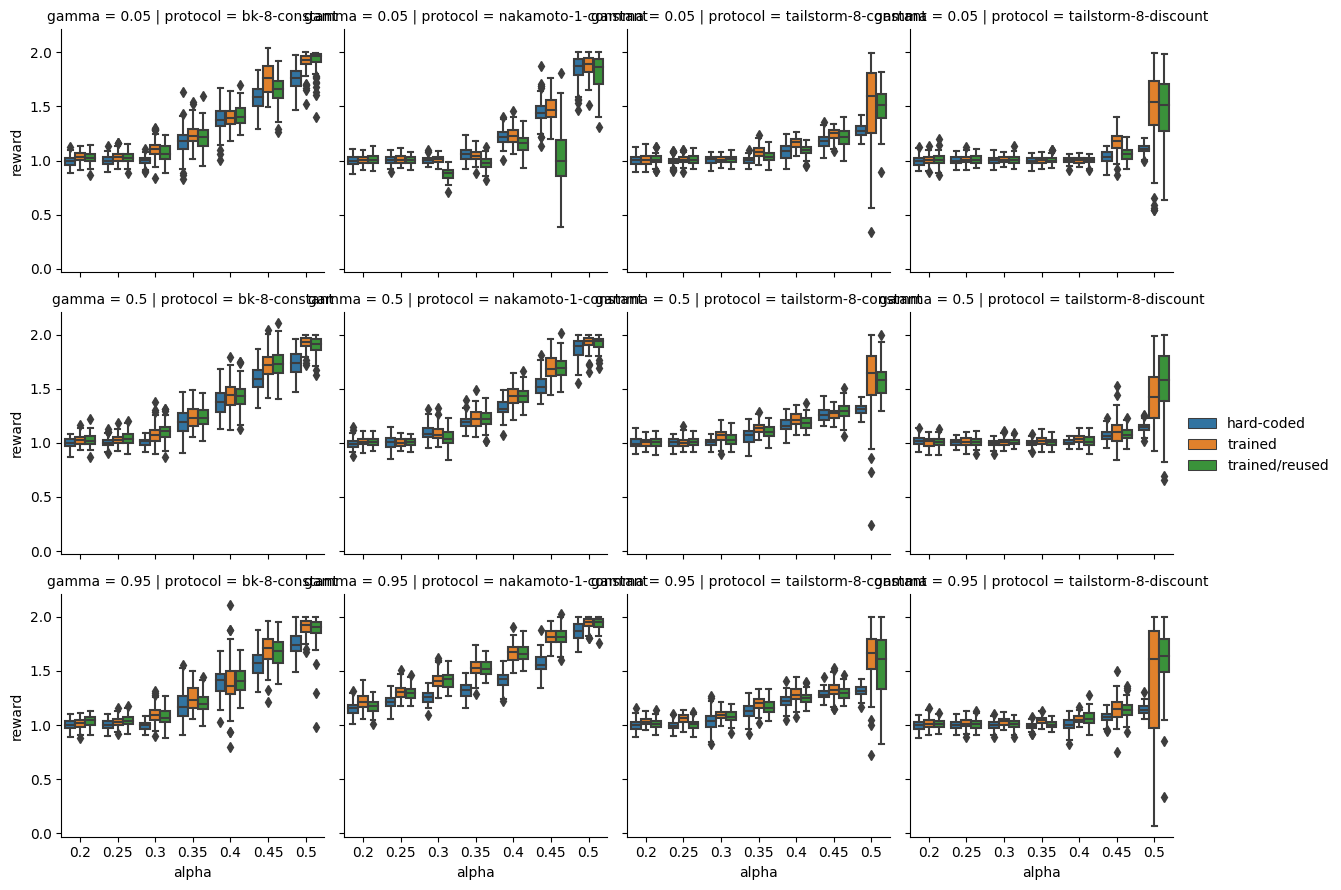

In [10]:
def rl_vs_hard_coded_bp(objective, label="reward"):
    d = opt_episodes.copy()
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.FacetGrid(
        data=d,
        # data=d.query("alpha >= .35"),
        col="protocol",
        row="gamma",
        sharex=True,
        sharey=True,
    )
    g.map_dataframe(
        sns.boxplot,
        x="alpha",
        y=label,
        hue="kind",
        orient="v",
        palette=sns.color_palette(),
    )
    g.add_legend()


## reward per progess (in DAA equilibrium)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress)
## alpha normalizations
rl_vs_hard_coded_bp(lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha)
# rl_vs_hard_coded(lambda d: d.episode_reward_attacker / d.episode_progress - d.alpha)

In [11]:
opt_policies.query('protocol == "tailstorm" and gamma==0.95 and alpha==.45').drop(
    columns=["path"]
)

,protocol,k,reward,subblock_selection,alpha,gamma,kind,reused,policy
177,tailstorm,8,constant,heuristic,0.45,0.95,hard-coded,False,minor-delay
178,tailstorm,8,constant,heuristic,0.45,0.95,trained,False,ppo-ha8ook2p_2
179,tailstorm,8,constant,heuristic,0.45,0.95,trained,True,ppo-5r4m6xp7_2
240,tailstorm,8,discount,heuristic,0.45,0.95,hard-coded,False,minor-delay
241,tailstorm,8,discount,heuristic,0.45,0.95,trained,False,ppo-7l4rhx8x-best
242,tailstorm,8,discount,heuristic,0.45,0.95,trained,True,ppo-ha8ook2p-best


/tmp/ipykernel_21537/3968487956.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  opt_episodes.groupby(


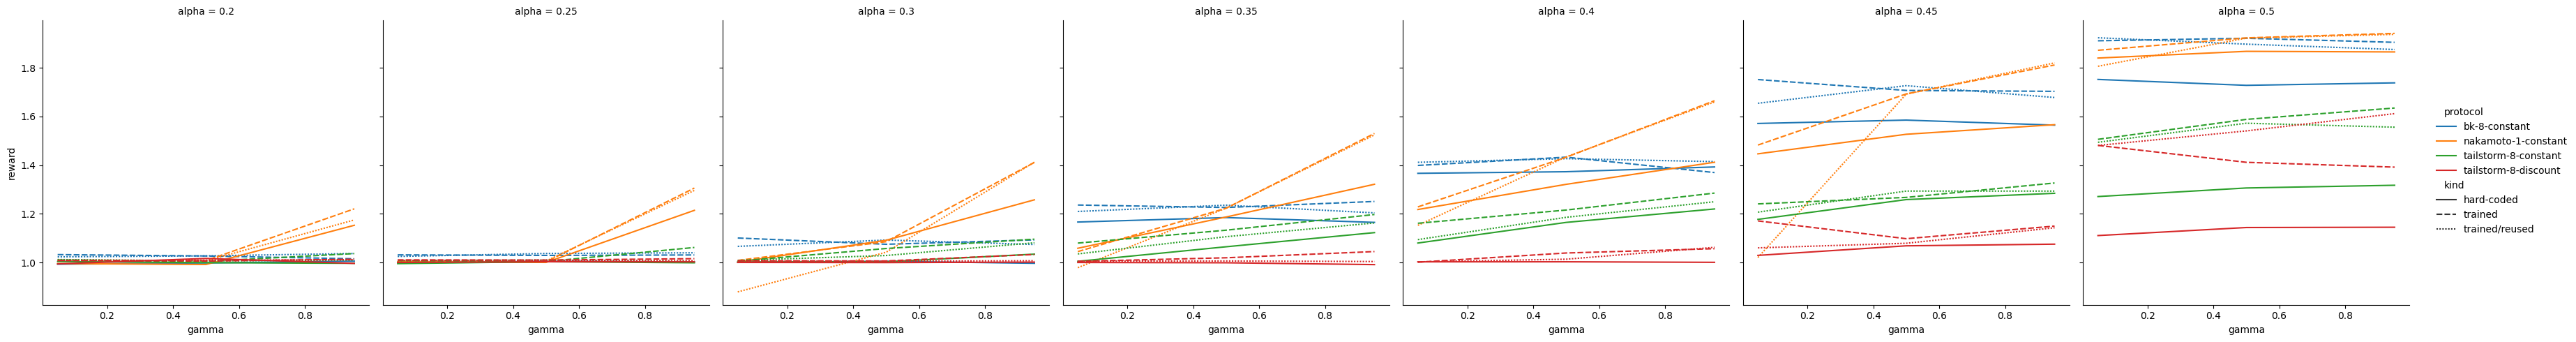

In [12]:
def rl_vs_hard_coded_gamma_lp(objective, label="reward"):
    d = (
        opt_episodes.groupby(
            [
                "protocol",
                "k",
                "reward",
                "subblock_selection",
                "alpha",
                "gamma",
                "kind",
                "reused",
                "policy",
            ]
        )
        .mean()
        .reset_index()
    )
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="alpha",
        x="gamma",
        y=label,
        style="kind",
    )


rl_vs_hard_coded_gamma_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)

/tmp/ipykernel_21537/4159778813.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  opt_episodes.groupby(


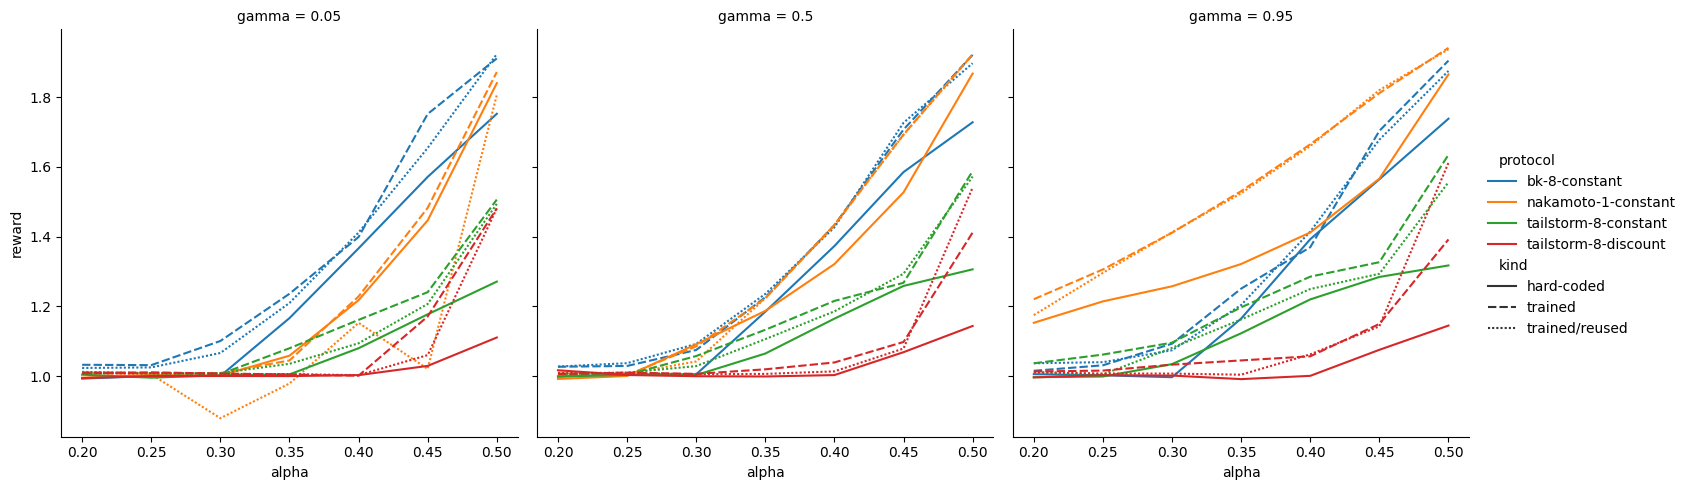

In [13]:
def rl_vs_hard_coded_alpha_lp(objective, label="reward"):
    d = (
        opt_episodes.groupby(
            [
                "protocol",
                "k",
                "reward",
                "subblock_selection",
                "alpha",
                "gamma",
                "kind",
                "reused",
                "policy",
            ]
        )
        .mean()
        .reset_index()
    )
    d.loc[d.reused, "kind"] = "trained/reused"
    d = (
        d.assign(
            protocol=d.protocol + "-" + d.k.map(str) + "-" + d.reward,
            kind=d.kind.astype("category"),
            __=objective(d),
        )
        .drop(columns=[label], errors="ignore")
        .rename(columns=dict(__=label))
    )
    g = sns.relplot(
        data=d,
        kind="line",
        hue="protocol",
        col="gamma",
        x="alpha",
        y=label,
        style="kind",
    )


rl_vs_hard_coded_alpha_lp(
    lambda d: d.episode_reward_attacker / d.episode_progress / d.alpha
)